# cleaning prototype

The goal of this notebook is to do some data processing, 
creating functions which will get thrown into a module.
The processing functions should grab everything from PG,
dedeuplicate records and create features.

In [1]:
import datetime as dt
from dateutil.parser import parse as date_parse
import pandas as pd
import matplotlib.pyplot as plt
from money_squirrel.bin import utils
from money_squirrel.bin.utils import query_pg

% matplotlib inline

plt.rcParams["figure.figsize"] = (10, 7)
plt.style.use("ggplot")

2017-04-28 07:21:51,296|money_squirrel.bin.utils|INFO|Instantiated logger w/ name=money_squirrel.bin.utils


In [2]:
query_pg("select count(*), product from gdax_gdaxprice where granularity=60 group by product")

2017-04-28 02:17:44,801|money_squirrel.bin.utils|INFO|Loading JSON from /Users/ravdek/code/money_squirrel/money_squirrel/config/postgres.json
2017-04-28 02:17:44,803|money_squirrel.bin.utils|INFO|Connecting to postgres DB @ localhost
2017-04-28 02:17:44,809|money_squirrel.bin.utils|INFO|Executing query:

select count(*), product from gdax_gdaxprice where granularity=60 group by product



,count,product
0,93633,ETH-USD
1,120321,BTC-USD
2,18195,LTC-USD


In [3]:
gdax_price = query_pg(
    """
    select distinct product
        , dt
        , low
        , high
        , open
        , close
        , volume
    from gdax_gdaxprice
    where granularity=60
    """
)

2017-04-28 02:17:47,841|money_squirrel.bin.utils|INFO|Loading JSON from /Users/ravdek/code/money_squirrel/money_squirrel/config/postgres.json
2017-04-28 02:17:47,842|money_squirrel.bin.utils|INFO|Connecting to postgres DB @ localhost
2017-04-28 02:17:47,846|money_squirrel.bin.utils|INFO|Executing query:


    select distinct product
        , dt
        , low
        , high
        , open
        , close
        , volume
    from gdax_gdaxprice
    where granularity=60
    



In [4]:
gdax_price.dt.min()

datetime.datetime(2016, 12, 31, 16, 0, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-480, name=None))

# Mental model for quantifying delta

```
delta(t1, t2) = E(X(t1, t1 + 20s) + ... + X(t2 - 20s, t2))
```
where X is the distribution of deltas between windows during that time period. 
Invoking CLT, for long periods of time, this will be distributed as
```
N(n_windows * mu_X, sigma_X)
```
**assuming** that the Xs are uncorrelated. This feels safe because of the random noise...

Being that our windows are 20 seconds, we would get 30 observations for a 10 minute window, 90 for 30 min, etc. This gives us "Sharpe ratios" for the returns during a time period. We can produce "noisy" features by sampling from this distribution.

To make features for price:
- For each product:
- 6 10 minute windows for the first hour
- 5 hour window for the rest of the 12 hour block
- 4 3 hour chunks for the rest of the day
- 6 day windows for the rest of the week
- 3 week windows for the rest of the 4 week period

For a total of 3*24=72 inputs without the google trends data

Outcome features:
- for each product
- 10 min delta
- hour delta
- 3 hour delta
- 6 hour delta
- day delta
- week delta

For a total of 24 dependent vars. We can then combine the estimates into something to be optimized or learned: Given estimates create an optimal action.

In order to simplify for a first analysis, we can just do rolling sums and standard deviations. This will result in lots of correlated variables, but this can be linearly tranformed into sums over buckets.

This will make computation easy for both this time series and the trends time series

In [5]:
close_df = gdax_price.pivot(columns='product', index='dt', values='close')

In [6]:
close_df.head(20)

product,BTC-USD,ETH-USD,LTC-USD
dt,,,
2016-12-31 16:00:00-08:00,973.35,8.16,NaN
2016-12-31 16:01:00-08:00,NaN,8.13,NaN
2016-12-31 16:02:00-08:00,NaN,8.11,NaN
2016-12-31 16:03:00-08:00,973.36,NaN,NaN
2016-12-31 16:04:00-08:00,973.39,8.11,NaN
2016-12-31 16:05:00-08:00,973.38,8.11,NaN
2016-12-31 16:06:00-08:00,973.38,8.11,NaN
2016-12-31 16:07:00-08:00,973.38,8.14,NaN
2016-12-31 16:08:00-08:00,972.01,8.14,NaN


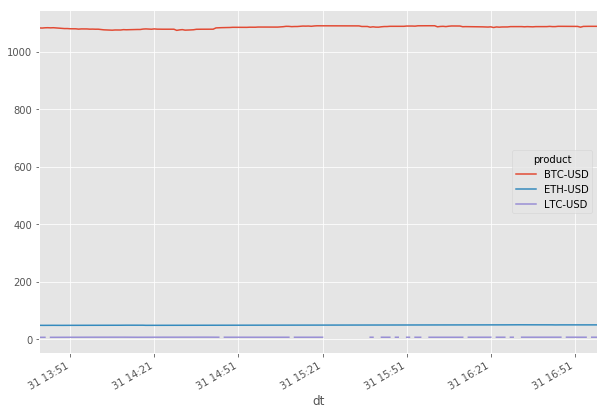

In [256]:
close_df = utils.fill_dt_gaps

In [258]:
volume_df = gdax_price.pivot(columns='product', index='dt', values='volume')

In [259]:
volume_df.head(100)

product,BTC-USD,ETH-USD,LTC-USD
dt,,,
2016-12-31 16:00:00-08:00,2.122048,6.097810,NaN
2016-12-31 16:01:00-08:00,NaN,31.484410,NaN
2016-12-31 16:02:00-08:00,NaN,100.000000,NaN
2016-12-31 16:03:00-08:00,0.040000,NaN,NaN
2016-12-31 16:04:00-08:00,5.458800,200.000000,NaN
2016-12-31 16:05:00-08:00,12.481567,100.000000,NaN
2016-12-31 16:06:00-08:00,1.496540,100.000000,NaN
2016-12-31 16:07:00-08:00,1.618820,264.045176,NaN
2016-12-31 16:08:00-08:00,13.581889,13.991670,NaN


In [260]:
volume_df.shape

(123695, 3)

In [261]:
volume_df.index = [float(t.strftime('%s')) for t in volume_df.index]

In [262]:
volume_df.head()

product,BTC-USD,ETH-USD,LTC-USD
1.483200e+09,2.122048,6.09781,NaN
1.483200e+09,NaN,31.48441,NaN
1.483200e+09,NaN,100.00000,NaN
1.483200e+09,0.040000,NaN,NaN
1.483200e+09,5.458800,200.00000,NaN


In [263]:
def dt_to_ts(datetime):
    return float(datetime.strftime('%s'))


def ts_to_dt(timestamp):
    return dt.datetime.fromtimestamp(timestamp)


def fill_dt_gaps(df, start_dt, end_dt, window_seconds, input_dt=True, output_dt=True):

    start_ts = dt_to_timestamp(start_dt)
    end_ts = dt_to_timestamp(end_dt)
    ts_range = [start_ts]
    while ts_range[-1] < end_ts:
        ts_range.append(ts_range[-1] + window_seconds)
    if input_dt:
        df.index = [dt_to_ts(t) for t in df.index]
    df = df.merge(
        pd.DataFrame(index=ts_range),
        left_index=True,
        right_index=True
    )
    if output_dt:
      df.index = [ts_to_dt(t) for t in df.index]
    return df

In [264]:
start_dt = dt.datetime(2017,01,01); end_dt=dt.datetime(2017,04,01)
start_ts, end_ts = dt_to_timestamp(start_dt), dt_to_timestamp(end_dt)
volume_df_restdate = volume_df[(volume_df.index <= end_ts) & (volume_df.index >= start_ts)]
volume_df_restdate.shape

(123232, 3)

In [265]:
volume_df_restdate.head()

product,BTC-USD,ETH-USD,LTC-USD
1.483229e+09,1.28591,NaN,NaN
1.483229e+09,5.00000,NaN,NaN
1.483229e+09,10.00000,NaN,NaN
1.483229e+09,1.93129,NaN,NaN
1.483229e+09,0.23708,2.99958,NaN


In [266]:
filled_volume = fill_dt_gaps(volume_df_restdate, start_dt, end_dt, 60, input_dt=False)

In [267]:
filled_volume.head()

,BTC-USD,ETH-USD,LTC-USD
2017-01-01 00:00:00,1.28591,NaN,NaN
2017-01-01 00:01:00,5.00000,NaN,NaN
2017-01-01 00:02:00,10.00000,NaN,NaN
2017-01-01 00:03:00,1.93129,NaN,NaN
2017-01-01 00:04:00,0.23708,2.99958,NaN


In [268]:
volume_df.head()

product,BTC-USD,ETH-USD,LTC-USD
1.483200e+09,2.122048,6.09781,NaN
1.483200e+09,NaN,31.48441,NaN
1.483200e+09,NaN,100.00000,NaN
1.483200e+09,0.040000,NaN,NaN
1.483200e+09,5.458800,200.00000,NaN


In [269]:
filled_volume.count()

BTC-USD    119874
ETH-USD     93367
LTC-USD     18180
dtype: int64

In [2]:
def get_price_features_60(start_dt, end_dt):

    df = utils.query_pg(
            """
            select distinct product
                , dt
                , close
                , volume
            from gdax_gdaxprice
            where granularity = 60
                and dt <= cast('{end_dt}' as timestamp)
                and dt >= cast('{start_dt}' as timestamp)
            """.format(
                start_dt=str(start_dt),
                end_dt=str(end_dt)
            )
    )
    close_df = df.pivot(
        columns='product',
        index='dt',
        values='close'
    ).sort_index()
    volume_df = df.pivot(
        columns='product',
        index='dt',
        values='volume'
    ).sort_index()
    output = close_df.merge(
        volume_df,
        how="outer",
        left_index=True,
        right_index=True,
        suffixes=('_close', '_volume')
    )
    return utils.fill_dt_gaps(
        output,
        start_dt,
        end_dt,
        window_seconds=60
    )


In [3]:
df = get_price_features_60(dt.datetime(2017,01,01), dt.datetime(2017,04,01))

2017-04-28 07:21:57,894|money_squirrel.bin.utils|INFO|Loading JSON from /Users/ravdek/code/money_squirrel/money_squirrel/config/postgres.json
2017-04-28 07:21:57,896|money_squirrel.bin.utils|INFO|Connecting to postgres DB @ localhost
2017-04-28 07:21:57,901|money_squirrel.bin.utils|INFO|Executing query:


            select distinct product
                , dt
                , close
                , volume
            from gdax_gdaxprice
            where granularity = 60
                and dt <= cast('2017-04-01 00:00:00' as timestamp)
                and dt >= cast('2017-01-01 00:00:00' as timestamp)
            



In [4]:
df.head()

,BTC-USD_close,ETH-USD_close,LTC-USD_close,BTC-USD_volume,ETH-USD_volume,LTC-USD_volume
2017-01-01 00:00:00,969.05,NaN,NaN,1.28591,NaN,NaN
2017-01-01 00:01:00,969.04,NaN,NaN,5.00000,NaN,NaN
2017-01-01 00:02:00,968.50,NaN,NaN,10.00000,NaN,NaN
2017-01-01 00:03:00,968.50,NaN,NaN,1.93129,NaN,NaN
2017-01-01 00:04:00,968.95,8.38,NaN,0.23708,2.99958,NaN


In [7]:
df.tail(1000)

,BTC-USD_close,ETH-USD_close,LTC-USD_close,BTC-USD_volume,ETH-USD_volume,LTC-USD_volume
2017-03-31 07:21:00,1050.96,49.95,6.24,1.319889,38.114864,401.211078
2017-03-31 07:22:00,1050.98,49.97,6.24,5.063300,214.258094,0.019173
2017-03-31 07:23:00,1050.98,49.89,6.23,2.253722,259.580072,4.933592
2017-03-31 07:24:00,1051.00,49.84,6.25,19.695007,20.440200,0.043053
2017-03-31 07:25:00,1050.99,49.87,NaN,3.142049,65.256200,NaN
2017-03-31 07:26:00,1051.27,49.88,6.21,2.059196,135.075400,259.962216
2017-03-31 07:27:00,1052.00,49.96,6.21,0.952800,101.868527,80.981411
2017-03-31 07:28:00,1050.99,49.87,6.20,3.009286,145.156695,33.820024
2017-03-31 07:29:00,1051.99,49.98,6.20,3.687608,83.465900,134.179976
2017-03-31 07:30:00,1052.00,50.00,6.21,73.382785,95.716400,3.050430


In [8]:
df[df['BTC-USD_close'].notnull()].tail()

,BTC-USD_close,ETH-USD_close,LTC-USD_close,BTC-USD_volume,ETH-USD_volume,LTC-USD_volume
2017-03-31 16:55:00,1088.98,50.13,7.25,1.337844,298.821148,4.030244
2017-03-31 16:56:00,1088.99,50.01,NaN,5.237900,19.882400,NaN
2017-03-31 16:57:00,1088.99,50.19,7.24,2.417300,62.065500,80.340000
2017-03-31 16:58:00,1088.99,50.18,7.25,2.365376,8.218400,196.765967
2017-03-31 16:59:00,1088.99,50.18,7.25,5.192415,2.293300,866.617261


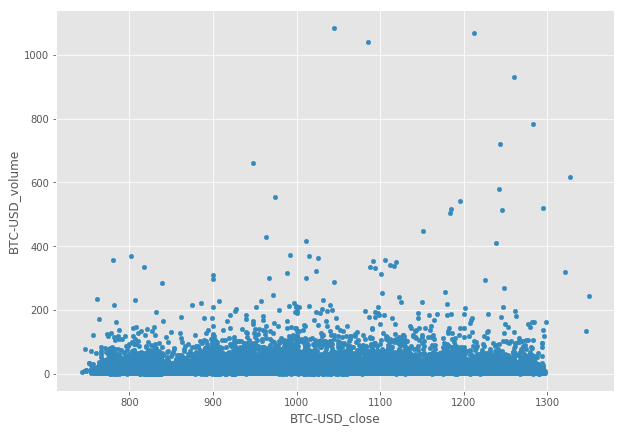